# <b><u>Network Anomaly Detection</u></b> 

E4 AIC group 7 :     
- JIANG Franck
- MURUGAVEL Shakthi
- RENOU Thibault
- TAHRAT Yanis


## Business Context

With the enormous growth of computer networks usage and the huge increase in the number of Applications running on top of it, network security is becoming increasingly more important. All The computer systems suffer from security vulnerabilities which are both technically difficult and economically costly to be solved by the manufacturers.\
Therefore, the role of Intrusion Detection Systems (IDSs), as special-purpose devices to detect anomalies and attacks in the network, is becoming more important. The research in the intrusion detection field has been mostly focused on anomaly-based and misusebased detection techniques for a long time. While misuse-based detection is generally favored in commercial products due to its predictability and high accuracy, in academic research anomaly detection is typically conceived as a more powerful method due to its theoretical potential for addressing novel attacks.\
Conducting a thorough analysis of the recent research trend in anomaly detection, one will encounter several machine learning methods reported to have a very high detection rate of 98% , while keeping the false alarm rate at 1%. However, when we look at the state of the art IDSs solutions and commercial tools, there is no evidence of using anomaly detection approaches, and practitioners still think that it is an immature technology.\
To find the reason of this contrast, lots of research was done done in anomaly detection and considered various aspects such as learning and detection approaches, training data sets, testing data sets, and evaluation methods.

## Business problem

Our purpose is to build network intrusion detection system to detect anomalies and attacks in the Network. The variable to predict is *attack*. There are 39 types of attacks and one normal state, when the network is not under attack. These attacks can be grouped into 4 types : *DOS*, *PROBE*, *R2L* and *U2R*. 

There are two problems:
- <u>Binomial Classification:</u> Activity is *normal* or *attack*;
- <u>Multinomial classification:</u> Activity is *normal*, *DOS*, *PROBE*, *R2L* or *U2R*;

For this project, <b>our objective will be to detect the type of attack</b> (*no attack*, *DOS*, *PROBE*, *R2L* or *U2R*).

# Import of packages

In [1]:
import time
import pickle
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import models, layers
from keras import optimizers

from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [2]:
# Modifiy the path to have access to your files

# Google colab environment 
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#projectPath = '/content/drive/My Drive/ESIEE/E4/AIC4101C_MachineLearning_project/' # Tibo
#projectPath = "/content/drive/MyDrive/AIC4101C_MachineLearning_project/"           # Franck and Shakthi and Yanis

# Local environment
projectPath = './'

# Implemented functions

Here are all the functions we have implemented during the project, so that we don't have to search and recompile them at their place of creation. Explanations about their implementation will be provided in their respective parts.

In [3]:
def one_hot_encoding(categorical):

    # 1. Instantiate
    oneHotEncoder = OneHotEncoder()
    
    # 2. Fit
    oneHotEncoder.fit(categorical)

    # 3. Transform
    encoded = oneHotEncoder.transform(categorical).toarray()

    # 4. Keep the result into a dataframe
    encoded = pd.DataFrame(encoded, columns=oneHotEncoder.get_feature_names_out())

    return encoded, oneHotEncoder

In [4]:
def truncation(data, labels, ratio=0.2): 
    # Truncation of the data
    trunc_data = data.sample(frac=1, random_state=42).reset_index()
    trunc_data = trunc_data.truncate( after = int(data.shape[0]*ratio) )
    trunc_data = trunc_data.drop(columns = 'index')    

    # Truncation of the labels
    trunc_labels = labels.sample(frac=1, random_state=42).reset_index()
    trunc_labels = trunc_labels.truncate( after = int(labels.shape[0]*ratio) )
    trunc_labels = trunc_labels.drop(columns = 'index')  
    
    return trunc_data, trunc_labels

In [5]:
def dataset_recovering(dataset_name):
    if dataset_name in ["normal", "chi2", "rfe"]:
        with open(projectPath+'data/dataset_'+dataset_name+'.pickle', 'rb') as fp :
            data, labels = pickle.load(fp) 
        return data, labels 
    else:
        print("ERROR: Please specify a conforming value for \'dataset_name\': \"normal\", \"chi2\", \"rfe\"")
        return (None,)*2

In [6]:
def SVM_train_test_split(data, labels, test_size=0.33, random_state=42):
    n = labels.shape[1]
    y_train_lst = [None]*n  # <-- [DoS, Probe, R2L, U2R, noAttack] 
    y_test_lst  = [None]*n  # <-- [DoS, Probe, R2L, U2R, noAttack]

    # 1. Initialization to treat each attack separately
    attacks_lst = []
    for i in range (n):
        attacks_lst.append(labels.columns[i]) # <-- [DoS, Probe, R2L, U2R, noAttack]

    # 2. Train test split
    for i in range(n):
        X_train, X_test, y_train_lst[i], y_test_lst[i] = train_test_split(data, labels[attacks_lst[i]], 
                                                                          test_size=test_size, 
                                                                          random_state=random_state,
                                                                          stratify=labels)
    return X_train, X_test, y_train_lst, y_test_lst

In [7]:
def SVM_fit(data, labels, X_train, X_test, y_train_lst, y_test_lst, C, max_iter):
    n = labels.shape[1]

    # 1. Initialization of the models
    model = [LinearSVC(C=C, max_iter=max_iter) for _ in range(n)]

    # 2. Fit
    for i in range(n):
        model[i].fit(X_train, y_train_lst[i])

    return model

In [8]:
def SVM_predict(model, X_test, computeScore=False, y_true=None):
    n = len(model)
    predictions_lst = []

    # 1. Prediction for each binary classification problem
    attacks_lst = []
    for i in range (n):
        attacks_lst.append(labels.columns[i])
        predictions_lst.append(model[i].predict(X_test))  

    # 2. Global prediction
    predictions = pd.DataFrame(np.array(predictions_lst).T)
    predictions.columns = attacks_lst

    # 3. Compute the score if requested
    if computeScore is True and y_true is not None:
        y_true = pd.DataFrame(np.array(y_true).T)
        y_true.columns = attacks_lst

        n_errors  = y_true.compare(predictions).shape[0]
        n_samples = y_true.shape[0]
        score = np.round( (n_samples-n_errors)/n_samples, 4 )

        return predictions, score

    elif computeScore is False:
        return predictions

    else :
        print("ERROR: Please specify conforming values for :\n\t - \'computeScore\': True, False \n\t - \'y_true\'")

In [9]:
def dataset_distribution(dataset_name, SVM_case=False, scaled=False, truncated=False, ratio=0.2):

    # 1. Dataset recovering
    data, labels = dataset_recovering(dataset_name)
    if data is None or labels is None:
        return (None,)*6

    # 2. Truncation 
    if truncated is True :
        data, labels = truncation(data, labels, ratio=ratio)
    elif truncated is not False:
        print("ERROR: Please specify a conforming value for \'truncated\': True, False")
        return (None,)*6

    # 3. Train test split 
    if SVM_case is False :
        X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                            test_size=0.33, 
                                                            random_state=42,
                                                            stratify=labels)
    elif SVM_case is True :
        X_train, X_test, y_train, y_test = SVM_train_test_split(data, labels, 
                                                                test_size=0.33, 
                                                                random_state=42)
    else :
        print("ERROR: Please specify a conforming value for \'SVM_case\': True, False")
        return (None,)*6

    # 4. Standardization
    if scaled is True :
        X_train = StandardScaler().fit_transform(X_train)
        X_test  = StandardScaler().fit_transform(X_test)
    elif scaled is not False:
        print("ERROR: Please specify a conforming value for \'scaled\': True, False")
        return (None,)*6

    return( data, labels, X_train, X_test, y_train, y_test )

# $\rm{I}$<b> - Data analysis and features engineering</b>

First of all, we will study manually the data set, by manipulating, deleting, modifying it in order to improve machine learning model training and to lead to better performance and greater accuracy.

In [10]:
df = pd.read_csv(projectPath+'data/Train.csv', index_col=False) 
print("Shape:", df.shape)
df.head()

Shape: (125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
print(df.dtypes) # display the name and the type of each column

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## $\rm{1)}$ Missing data and duplicates 

First of all, we will check if there is NaN values in the studied dataframe. Then we will check if there are duplicated rows, in order to delete them (no need to do it for the columns, we can see with the human eye that there are no duplicates).

In [12]:
# Missing values
print("missing values:", df.isnull().sum().sum()) # 0, no missing value

# Duplicates
print("number of rows before dropping duplicates :", df.shape[0]) # 125 973
df = df.drop_duplicates()
print("number of rows after dropping duplicates  :", df.shape[0]) # 125 973, no duplicated rows

missing values: 0
number of rows before dropping duplicates : 125973
number of rows after dropping duplicates  : 125973


## $\rm{2)}$ Grouping the types of attacks

We know that there are 39 types of attacks and one normal state, when the network is not under attack. Here, the purpose will be to group these attacks into 4 types : DOS, PROBE, R2L and U2R.

In [13]:
# List all the attacks identified in the .csv file
attacks = sorted( df['attack'].unique() )
print( str(len(attacks)) + " different attacks:\n- " + '\n- '.join([f'{i}' for i in attacks]) )

23 different attacks:
- back
- buffer_overflow
- ftp_write
- guess_passwd
- imap
- ipsweep
- land
- loadmodule
- multihop
- neptune
- nmap
- normal
- perl
- phf
- pod
- portsweep
- rootkit
- satan
- smurf
- spy
- teardrop
- warezclient
- warezmaster


In [14]:
# Group the types of attack
types_of_attacks = {'normal': 'noAttack', 
                    
                    'back'     : 'DoS',
                    'land'     : 'DoS',
                    'neptune'  : 'DoS', 
                    'pod'      : 'DoS',
                    'smurf'    : 'DoS',
                    'teardrop' : 'DoS',
                                    
                    'ipsweep'  : 'Probe',
                    'nmap'     : 'Probe',
                    'portsweep': 'Probe',
                    'satan'    : 'Probe',
                    
                    'ftp_write'   : 'R2L',
                    'guess_passwd': 'R2L',
                    'imap'        : 'R2L', 
                    'multihop'    : 'R2L', 
                    'phf'         : 'R2L',
                    'spy'         : 'R2L',
                    'warezclient' : 'R2L',
                    'warezmaster' : 'R2L', 
                    
                    'buffer_overflow': 'U2R',
                    'loadmodule'     : 'U2R', 
                    'perl'           : 'U2R',
                    'rootkit'        : 'U2R'
                    }

print(len(types_of_attacks)) # should be 23

23


In [15]:
# Replace each attack by its group
new_attacks = []
for i in df['attack']:
  new_attacks.append( types_of_attacks[i] )

df['attack'] = new_attacks

print("Shape:", df.shape)
df.head(15)

Shape: (125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,noAttack,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,noAttack,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,noAttack,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,noAttack,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,DoS,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,DoS,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,DoS,21


## $\rm{3)}$ Deleting uninformative variables

Now, the purpose will be to analyse our data in order to detect which variables are relevant for the study, and which ones are not. It will then be possible to delete uninformative variables.

### $\rm{3.a)}$ study of the variable is_host_login

<AxesSubplot:xlabel='attack', ylabel='is_host_login'>

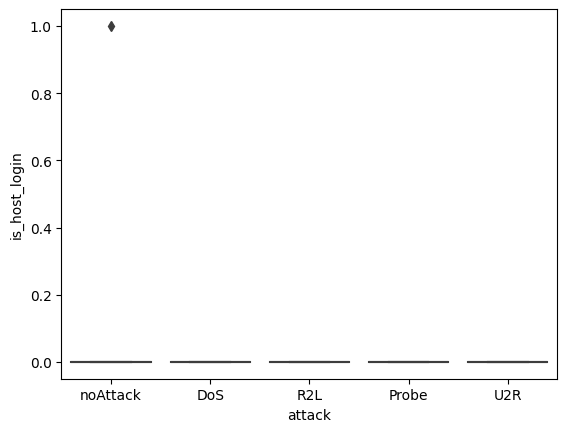

In [16]:
sns.boxplot(x='attack', y='is_host_login', data=df) # we can see some outliers 

In [17]:
outliers = df[df['is_host_login'] != 0]
print("number of rows where is_host_login!=0 :", outliers.shape[0]) # only one outlier, uninformative variable

df = df.drop('is_host_login', axis=1) # we decide to remove the feature
print(df.shape) # should be (..,42)

number of rows where is_host_login!=0 : 1
(125973, 42)


### $\rm{3.b)}$ study of the variable num_outbound_cmds

<AxesSubplot:xlabel='attack', ylabel='num_outbound_cmds'>

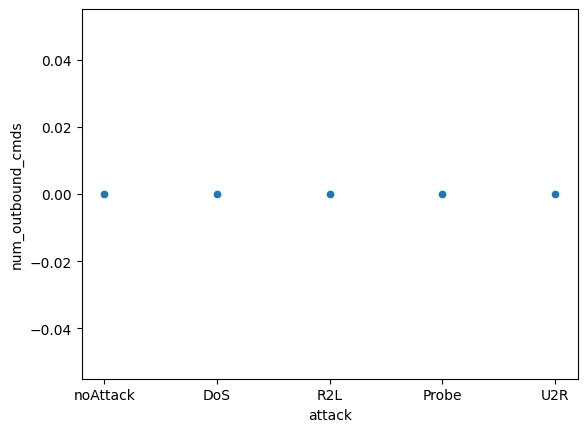

In [18]:
sns.scatterplot(x='attack', y='num_outbound_cmds', data=df) 

In [19]:
print("number of rows where num_outbound_cmds!=0 :",  df[df['num_outbound_cmds']!=0].shape[0] ) # always equal to 0
df = df.drop('num_outbound_cmds', axis=1) # uninformative variable, we decide to remove it
print(df.shape) # should be (..,41)

number of rows where num_outbound_cmds!=0 : 0
(125973, 41)


### $\rm{3.c)}$ study of the variable su_attempted

<AxesSubplot:xlabel='attack', ylabel='su_attempted'>

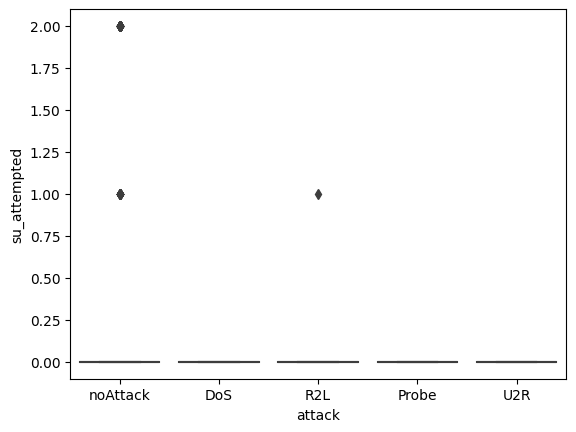

In [20]:
sns.boxplot(x='attack', y='su_attempted', data=df) # we can see some outliers

In [21]:
outliers1 = df[df['su_attempted'] == 1]
outliers2 = df[df['su_attempted'] == 2]
print("number of rows where su_attempted==1 :", outliers1.shape[0])        # 21 mixed attacks with su_attempted==1
print("number of rows where su_attempted==2 :", outliers2.shape[0])        # 59 noAttack rows with su_attempted==2
print("total of noAttack cases:", df[df['attack'] == 'noAttack'].shape[0]) # 67_343 total noAttack 

# For this feature, we have 59 out of 67_343 noAttack that can be detected --> 0.0876%, too low

number of rows where su_attempted==1 : 21
number of rows where su_attempted==2 : 59
total of noAttack cases: 67343


In [22]:
df = df.drop('su_attempted', axis=1) # uninformative variable, we decide to remove it
print(df.shape) # should be 40

(125973, 40)


### $\rm{3.d)}$ study of the variable urgent

<AxesSubplot:xlabel='attack', ylabel='urgent'>

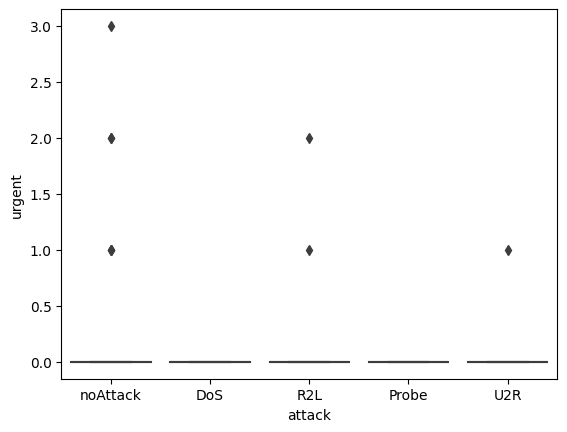

In [23]:
sns.boxplot(x='attack', y='urgent', data=df) # we can see some outliers

In [24]:
print("number of rows where urgent!=0 :", df[df['urgent'] != 0].shape[0])  # 9 rows to describe mixed attacks 
df = df.drop('urgent', axis=1) # uninformative variable, we decide to remove the feature
print(df.shape) # should be 39

number of rows where urgent!=0 : 9
(125973, 39)


## $\rm{4)}$ Extracting the labels and the data

Now that we have manipulated the data, our goal will be to generate a dataset to work with in the next parts. First, we will extract the attack variable from the dataframe because these are our target variables.

In [25]:
labels = df[['attack']]
labels.head()

,attack
0,noAttack
1,noAttack
2,DoS
3,noAttack
4,noAttack


In [26]:
df.drop(['attack'], axis=1, inplace=True)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21


## $\rm{5)}$ One-hot encoding for categorical variables

By displaying the types of all features at the beginning of this part, we saw that there are some categorical variables. We will then transform strings into numerical values by using One hot encoding, a method of converting data to prepare it for an algorithm and get a better prediction.

In [27]:
# Display categorical variables
categorical = df.select_dtypes(include=[object])
print(categorical.shape)
categorical.head(3)

(125973, 3)


,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0


In [28]:
def one_hot_encoding(categorical):

    # 1. Instantiate
    oneHotEncoder = OneHotEncoder()
    
    # 2. Fit
    oneHotEncoder.fit(categorical)

    # 3. Transform
    encoded = oneHotEncoder.transform(categorical).toarray()

    # 4. Keep the result into a dataframe
    encoded = pd.DataFrame(encoded, columns=oneHotEncoder.get_feature_names_out())

    return encoded, oneHotEncoder

In [29]:
encoded, oneHotEncoder = one_hot_encoding(categorical)

print(encoded.shape)
encoded.head(5)

(125973, 84)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
labels_encoded ,_ = one_hot_encoding(labels)

print(labels_encoded.shape)
labels_encoded.head(5)

(125973, 5)


,attack_DoS,attack_Probe,attack_R2L,attack_U2R,attack_noAttack
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0


Once that we have encoded the labels and categorical variables from the dataframe, we can generate our cleaned dataset by adding the result from one hot encoding to the original dataframe.

In [31]:
# Drop the categorical data from the original dataframe
print("df shape before dropping:", df.shape)
df.drop(df.select_dtypes(include=[object]), axis=1, inplace=True)  
print("df shape after dropping :", df.shape)

# Join the oneHotEncoded data to the dataframe
data = df.join(encoded) 
print(data.shape)
data.head(5)

df shape before dropping: (125973, 38)
df shape after dropping : (125973, 35)
(125973, 119)


,duration,src_bytes,dst_bytes,land,wrong_fragment,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## $\rm{6)}$ Stocking useful variables into a .picke file

Finally, we will stock the cleaned dataset and the oneHotEncoder() generated thanks to the previous part into .pickle files, in order to work with them for the future, without having to repeat the previous steps each time.

In [32]:
dataset_normal = (data, labels_encoded)               # we store our dataset in a variable

with open('./data/dataset_normal.pickle', 'wb') as p: # we create the .pickle file
    pickle.dump(dataset_normal, p)                    # we put the data of the variable in the .pickle file

with open('./data/oneHotEncoder.pickle', 'wb') as p:  # we create the .pickle file
    pickle.dump(oneHotEncoder, p)                     # we put the data of the variable in the .pickle file

## $\rm{7)}$ Taking a smaller dataset
Since we have more than 100 000 data in our dataset, we can try to train our models on a smaller dataset to see how many data we need to have a good model (let's say accuracy > 95%). We will then implement a function *truncation()* that will be useful to us for the model selection, in the part $\rm{III-1)}$ :

In [33]:
def truncation(data, labels, ratio=0.2): 
    # Truncation of the data
    trunc_data = data.sample(frac=1, random_state=42).reset_index()
    trunc_data = trunc_data.truncate( after = int(data.shape[0]*ratio) )
    trunc_data = trunc_data.drop(columns = 'index')    

    # Truncation of the labels
    trunc_labels = labels.sample(frac=1, random_state=42).reset_index()
    trunc_labels = trunc_labels.truncate( after = int(labels.shape[0]*ratio) )
    trunc_labels = trunc_labels.drop(columns = 'index')  
    
    return trunc_data, trunc_labels

In [34]:
labels = labels_encoded
print(data.shape)
print(labels.shape)

trunc_data, trunc_labels = truncation(data, labels)
print(trunc_data.shape)
print(trunc_labels.shape)

(125973, 119)
(125973, 5)
(25195, 119)
(25195, 5)


# Recovering the dataset from the features engineering

To easily work with our dataset made during the part $\rm{I}$, we can recover it from the *dataset_normal.pickle* file as it follows :

In [35]:
with open(projectPath+'/data/dataset_normal.pickle', 'rb') as fp : # we recover the .pickle file
    dataset_normal = pickle.load(fp)                               # we recover the dataset from the .pickle file

(data, labels) = dataset_normal                                    # we recover the data and the labels from the dataset

# $\rm{II}$<b> - Feature selection</b>

There are three general classes of feature selection algorithms: filter methods, wrapper methods and embedded methods.

<b>1. Filter methods</b>

Filter feature selection methods apply a statistical measure to assign a scoring to each feature. The features are ranked by the score and either selected to be kept or removed from the dataset. The methods are often univariate and consider the feature independently, or with regard to the dependent variable.

Some examples of some filter methods include the Chi squared test, information gain and correlation coefficient scores.


<b>2. Wrapper methods</b>

Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. A predictive model is used to evaluate a combination of features and assign a score based on model accuracy.

An example if a wrapper method is the recursive feature elimination algorithm.

<b>3. Embedded methods</b>

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created. The most common type of embedded feature selection methods are regularization methods.

Regularization methods are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients).

Examples of regularization algorithms are the LASSO, Elastic Net and Ridge Regression. Those algorithms performs the best in the regression analysis, so we won't use them for this project.

### $\rm{1)}$ Base performance

Let’s establish a base performance with a Random Forest Classifier. We will first build the feature and target arrays and divide them into train and test sets. Then, we will fit the estimator and see which score we can obtain:

In [36]:
# Dataset distribution 
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=labels)
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)

# Scale train and test sets with StandardScaler <-- not normally required for a Random Forest
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

X_train : (84401, 119)
X_test  : (41572, 119)
y_train : (84401, 5)
y_test  : (41572, 5)


In [37]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)
#forest.fit(X_train_std, y_train) # <-- std

forest_score = forest.score(X_test, y_test)
#forest_score = forest.score(X_test_std, y_test) # <-- std

print('Random forest score: {:.4f}'.format(forest_score)) # Random forest score: 0.9994 --> 0.9707 with std

Random forest score: 0.9994


Here, we achieved an excellent score of 0.9994. We could do this using all 119 features, which is much more than we might need. All Sklearn estimators have special attributes that show feature weights, thanks to the <i>feature_importances_</i> attribute. Let's see the computed coefficients for our Random Forest Classifier model:

In [38]:
features_importances = pd.DataFrame(
    zip(X_train.columns, abs(forest.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight").reset_index(drop=True)

features_importances

,feature,weight
0,service_http_8001,0.000000e+00
1,service_http_2784,0.000000e+00
2,service_aol,6.459507e-13
3,service_vmnet,1.379912e-07
4,service_netbios_dgm,1.567478e-07
...,...,...
114,flag_SF,4.988358e-02
115,same_srv_rate,6.272203e-02
116,diff_srv_rate,6.660119e-02
117,dst_bytes,7.140417e-02


Since all weights are multiplied by the values of features, such small weights contribute very little to the overall predictions. Looking at the above weights, we can see that many weights are close to 0. We will start by deleting them in order to reduce model complexity.

### $\rm{2)}$ Filter method : Chi squared test

The Chi-squared test is used in statistics to test the independence of two events. More specifically in feature selection we will use it to test whether the occurrence of a specific feature and the target are independent or not.

The purpose is to calculate Chi-square between each feature and the target, in order to select the desired number of features with best Chi-square scores or the lowest p-values, because it implies that the target column is dependent on the feature column.

In [39]:
# Create and fit selector
selector = SelectKBest(chi2, k=39) # k is the number of features we want to keep
selector.fit_transform(data, labels)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
data_chi2 = data.iloc[:,cols]

# Dataset distribution 
X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(data_chi2, labels, 
                                                       test_size=0.33, 
                                                       random_state=42,
                                                       stratify=labels)
# Init, fit, score
forest = RandomForestClassifier()
forest.fit(X_train_chi2, y_train_chi2)
forest_score = forest.score(X_test_chi2, y_test_chi2)

# recap
print('Random forest score with chi2: {:.4f}'.format(forest_score))

# n features kept  : |    5    |    10    |   20    |   35    |   37    |   39    |   40    |   80    |
# score with chi2  : | 0.9894  |  0.9944  | 0.9978  | 0.9992  | 0.9993  | 0.9994  | 0.9994  | 0.9994  |  

Random forest score with chi2: 0.9994


We can see that from 39 features, the best score is reached and doesn't change anymore. It is interesting to know that we can delete 80 features whitout loosing accuracy.

We can have a look on the 39 most important features :

In [40]:
data_chi2.columns.values

array(['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in',
       'num_compromised', 'root_shell', 'num_root', 'is_guest_login',
       'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'last_flag',
       'protocol_type_icmp', 'service_domain_u', 'service_eco_i',
       'service_ftp', 'service_ftp_data', 'service_http',
       'service_private', 'flag_RSTR', 'flag_S0', 'flag_SF'], dtype=object)

In order to reuse this dataset later, we will stock the result into a *.pickle* file

In [41]:
dataset_chi2 = (data_chi2, labels)

with open('./data/dataset_chi2.pickle', 'wb') as p:
    pickle.dump(dataset_chi2, p)

### $\rm{3)}$ Wrapper method: Recursive Feature Elimination (RFE)

RFE is a transformer estimator, which is a popular algorithm due to its easy configurable nature and robust performance. 
RFE reduces model complexity by removing features one by one until the optimal number of features is left.

It is one of the most popular feature selection algorithms due to its flexibility and ease of use. The algorithm can wrap around any model, and it produces the best possible set of features that gives the highest performance.

In [42]:
# Init the transformer
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=80, step=10)

# Fit to the training data
rfe.fit(X_train, y_train)

# Init, fit, score
forest = RandomForestClassifier()
forest.fit(rfe.transform(X_train), y_train)
forest_score = forest.score(rfe.transform(X_test), y_test)

# Recap
print('Random forest score with rfe: {:.4f}'.format(forest_score))

# n features kept  : |    5    |    10    |   20    |   40    |   80    |
# score with rfe   : | 0.9924  |  0.9985  | 0.9991  | 0.9994  | 0.9994  | 

Random forest score with rfe: 0.9994


Here, we can see that we tried different values corresponding on the number of features we want to keep for our model. 

We can notice that by keeping only 10 features or less, the score becomes less efficient. On the other hand, we can see that from 40 features the score reaches a ceiling and does not exceed 0.9994, which is the same result as when we work with all of the 119 features.

Now, we have to choose the number of relevant features based on their performance. To achieve this, we will use a RFECV class which implements Recursive Feature Elimination with Cross-Validation and automatically finds the optimal number of features to keep:

In [43]:
start = time.time()

# Init the transformer
rfecv = RFECV(
    estimator=RandomForestClassifier(),
    min_features_to_select=10,
    step=10,
    cv=5,
)

# Fit to the training data
rfecv.fit(X_train, y_train)

# Init, fit, score
forest_cv = RandomForestClassifier()
forest_cv.fit(rfecv.transform(X_train), y_train)
forest_cv_score = forest_cv.score(rfecv.transform(X_test), y_test)

# recap
seconds = round(time.time() - start)
minutes = seconds // 60
seconds %= 60
print('Random forest score with rfecv: {:.4f}'.format(forest_cv_score)) # Score: 0.9994
print('Elapsed time: {}min {}s'.format(minutes, seconds))               # Elapsed time: 14min49s

Random forest score with rfecv: 0.9994
Elapsed time: 14min 49s


After fitting the estimator, it has a <i>support_</i> attribute that gives a boolean mask with <i>False</i> values for discarded features. We can use it to subset our data:

In [44]:
print(data.columns[rfecv.support_].shape)
print(data.columns[rfecv.support_])

(49,)
Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot',
       'logged_in', 'num_compromised', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'last_flag', 'protocol_type_icmp',
       'protocol_type_tcp', 'protocol_type_udp', 'service_domain_u',
       'service_eco_i', 'service_ecr_i', 'service_finger', 'service_ftp',
       'service_ftp_data', 'service_http', 'service_other', 'service_private',
       'service_smtp', 'service_telnet', 'service_urp_i', 'flag_REJ',
       'flag_RSTO', 'flag_RSTR', 'flag_S0', 'flag_SF', 'flag_SH'],
      dtype='object'

We can conclude that thanks to the RFECV class, we can keep only 49 features out of 119 and that even after dropping 70 features, we still got an impressive score of 0.9994, which is the same score as the base performance with all the features.

We can now keep this new dataframe with the target features into a dataset, in order to use it for later: 

In [45]:
data_rfe = data.loc[:, rfecv.support_]
dataset_rfe = (data_rfe, labels)

with open('./data/dataset_rfe.pickle', 'wb') as p:
    pickle.dump(dataset_rfe, p) 

# $\rm{III}$<b> - Model selection</b>

To easily manage the dataset we want to work with for our models, we will implement a function to recover the desired dataset called *dataset_recovering*, and another called *dataset_distribution* that will allows to: 
- use *recover_dataset()*;
- truncate or not the dataset for a desired *ratio*;
- apply a dataset distribution with *train_test_split()*;
- apply or not a standardization on train and test sets with *StandardScaler()*;

In [46]:
def dataset_recovering(dataset_name):
    if dataset_name in ["normal", "chi2", "rfe"]:
        with open(projectPath+'data/dataset_'+dataset_name+'.pickle', 'rb') as fp :
            dataset = pickle.load(fp) 
        return dataset 
    else:
        print("ERROR: Please specify a conforming value for \'dataset_name\': \"normal\", \"chi2\", \"rfe\"")
        return (None,)*2

In [47]:
def dataset_distribution(dataset_name, SVM_case=False, scaled=False, truncated=False, ratio=0.2):

    # 1. Dataset recovering
    data, labels = dataset_recovering(dataset_name)
    if data is None or labels is None:
        return (None,)*6

    # 2. Truncation 
    if truncated is True :
        data, labels = truncation(data, labels, ratio=ratio)
    elif truncated is not False:
        print("ERROR: Please specify a conforming value for \'truncated\': True, False")
        return (None,)*6

    # 3. Train test split 
    if SVM_case is False :
        X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                            test_size=0.33, 
                                                            random_state=42,
                                                            stratify=labels)
    elif SVM_case is True :
        X_train, X_test, y_train, y_test = SVM_train_test_split(data, labels, 
                                                                test_size=0.33, 
                                                                random_state=42)
    else :
        print("ERROR: Please specify a conforming value for \'SVM_case\': True, False")
        return (None,)*6

    # 4. Standardization
    if scaled is True :
        X_train = StandardScaler().fit_transform(X_train)
        X_test  = StandardScaler().fit_transform(X_test)
    elif scaled is not False:
        print("ERROR: Please specify a conforming value for \'scaled\': True, False")
        return (None,)*6

    return( data, labels, X_train, X_test, y_train, y_test )

## $\rm{1)}$ Support-Vector Machine (SVM)


A Support Vector Machine (SVM) is a supervised machine learning algorithm that can be used in both classification and regression problems.

In its most simple type, SVM doesn’t support multiclass classification natively. It supports binary classification and separating data points into two classes. For multiclass classification, the same principle is utilized after breaking down the multiclassification problem into multiple binary classification problems.

To avoid code repetition due to the separation of the multiclassification problem into several binary classification problems, we implemented three functions :

- *SVM_train_test_split()* which uses *train_test_split()* for each binary classification problem;
- *SVM_fit()* which instantiates a model for each binary classification problem, fit it with its data generated by the previous function, then return all the fitted models;
- *SVM_predict()* which makes a prediction for each binary classification problem, then makes a global prediction. We can also decide to calculate the score of the prediction with *y_true*; 

In [48]:
def SVM_train_test_split(data, labels, test_size=0.33, random_state=42):
    n = labels.shape[1]
    y_train_lst = [None]*n  # <-- [DoS, Probe, R2L, U2R, noAttack] 
    y_test_lst  = [None]*n  # <-- [DoS, Probe, R2L, U2R, noAttack]

    # 1. Initialization to treat each attack separately
    attacks_lst = []
    for i in range (n):
        attacks_lst.append(labels.columns[i]) # <-- [DoS, Probe, R2L, U2R, noAttack]

    # 2. Train test split
    for i in range(n):
        X_train, X_test, y_train_lst[i], y_test_lst[i] = train_test_split(data, labels[attacks_lst[i]], 
                                                                          test_size=test_size, 
                                                                          random_state=random_state,
                                                                          stratify=labels)
    return X_train, X_test, y_train_lst, y_test_lst

In [49]:
def SVM_fit(data, labels, X_train, X_test, y_train_lst, y_test_lst, C, max_iter):
    n = labels.shape[1]

    # 1. Initialization of the models
    model = [LinearSVC(C=C, max_iter=max_iter) for _ in range(n)]

    # 2. Fit
    for i in range(n):
        model[i].fit(X_train, y_train_lst[i])

    return model

In [50]:
def SVM_predict(model, X_test, computeScore=False, y_true=None):
    n = len(model)
    predictions_lst = []

    # 1. Prediction for each binary classification problem
    attacks_lst = []
    for i in range (n):
        attacks_lst.append(labels.columns[i])
        predictions_lst.append(model[i].predict(X_test))  

    # 2. Global prediction
    predictions = pd.DataFrame(np.array(predictions_lst).T)
    predictions.columns = attacks_lst

    # 3. Compute the score if requested
    if computeScore is True and y_true is not None:
        y_true = pd.DataFrame(np.array(y_true).T)
        y_true.columns = attacks_lst

        n_errors  = y_true.compare(predictions).shape[0]
        n_samples = y_true.shape[0]
        score = np.round( (n_samples-n_errors)/n_samples, 4 )

        return predictions, score

    elif computeScore is False:
        return predictions

    else :
        print("ERROR: Please specify conforming values for :\n\t - \'computeScore\': True, False \n\t - \'y_true\'")

We can then stock our variables for the desired dataset thanks to the function *dataset_distribution()* for our model as it follows:

In [51]:
# Scaled
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal", SVM_case=True, scaled=True)
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2"  , SVM_case=True, scaled=True)
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe"   , SVM_case=True, scaled=True)
#max_iter = 1e3

# Truncated and scaled
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal", SVM_case=True, scaled=True, truncated=True)
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2"  , SVM_case=True, scaled=True, truncated=True)
data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe"   , SVM_case=True, scaled=True, truncated=True)
max_iter = 1e6

Once that we recovered the variables, we can try different values for each hyper-parameter on each of our datasets, by fitting the model and do some predictions :

In [52]:
start = time.time()

# fit
SVM_model = SVM_fit(data, labels, X_train, X_test, y_train, y_test, C=0.4, max_iter=max_iter)

# predict and score
SVM_predictions, SVM_score = SVM_predict(SVM_model, X_test, computeScore=True, y_true=y_test)

seconds = round(time.time() - start)

We can now have a look on the predictions made by the SVM model, as well as the different scores and computation times obtained :

In [53]:
SVM_predictions.head()

,attack_DoS,attack_Probe,attack_R2L,attack_U2R,attack_noAttack
0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0


In [54]:
minutes = seconds // 60
seconds %= 60
print('SVM score: {:.4f}'.format(SVM_score))
print('Elapsed time: {}min {}s'.format(minutes, seconds))  

# Scaled
# dataset used      : |   normal   |    chi2    |     rfe    | 
# best hyper-params : | {0.4, 1e3} | {0.4, 1e3} | {0.4, 1e3} | <-- format: {'C', 'max_iter'}
# score on test set : |   0.9839   |   0.9692   |   0.9806   |    
# computation time  : |   1min09s  |     38s    |     38s    |

# Truncated and scaled
# dataset used      : |   normal   |    chi2    |     rfe    | 
# best hyper-params : | {0.4, 1e6} | {0.4, 1e6} | {0.4, 1e6} | <-- format: {'C', 'max_iter'}
# score on test set : |   0.9774   |   0.9639   |   0.9773   |    
# computation time  : |     28s    |     8s     |     7s     |

SVM score: 0.9768
Elapsed time: 0min 8s


As we can see, by working with only the 49 features chosen thanks to RFE algorithm, we are able to save a lot of time without losing much precision (0.9838 to 0.9806 and 1min09s to 38s). 

Moreover, with the truncated dataset_rfe (here we kept 20% of the dataset), we reduced the computation by almost 5, while keeping a great accuracy score (0.9773)


 For the SVM, we will then keep the dataset_rfe because we have a better score for a shorter computation time.

The question is now to know the optimal percentage of the dataset to keep an accuracy that remains high :

In [55]:
warnings.filterwarnings("ignore")
ratio_range= [0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
times = []
test_acc = []
for ratio in ratio_range:
    data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe", SVM_case=True, scaled=True, truncated=True, ratio=ratio)
    start = time.time()

    model = SVM_fit(data, labels, X_train, X_test, y_train, y_test, C=0.4, max_iter=1e3)
    _, SVM_score = SVM_predict(model, X_test, computeScore=True, y_true=y_test)

    seconds = round(time.time() - start)
    test_acc.append(SVM_score)
    times.append(seconds)

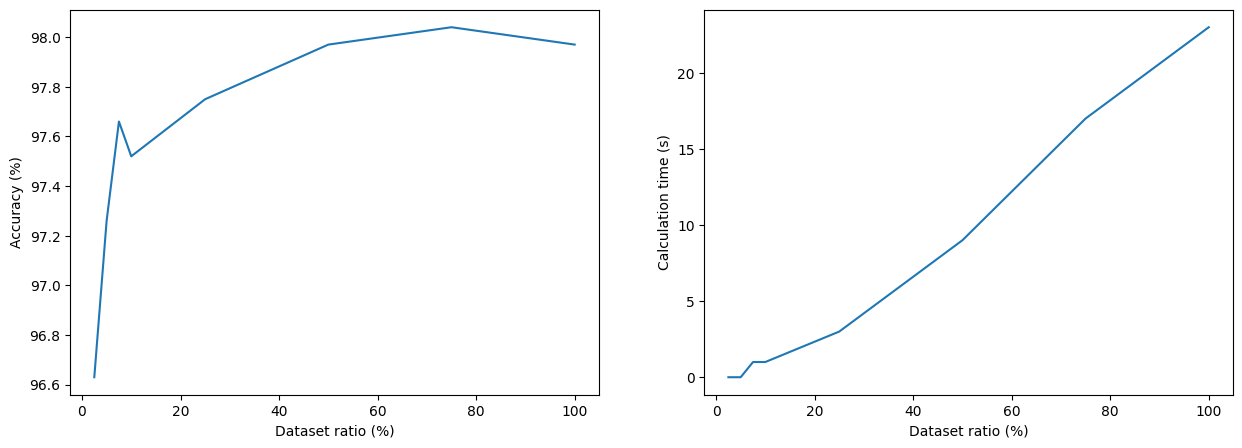

In [56]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.plot( np.array(ratio_range)*100 , np.array(test_acc)*100)
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Accuracy (%)")

#plot 2:
plt.subplot(1, 2, 2)
plt.plot( np.array(ratio_range)*100 , np.array(times) )
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Calculation time (s)")

plt.show()

Thanks to the plots, we can conclude for a SVM that it is better to work with only 50% of the dataset, because it allows us to keep a good accuracy while having a computation time that is lower than 10s.

However, one of the biggest drawbacks of this model is that we could have several attacks predicted for the same event, or on the contrary no prediction made due to the fact that we group five independent binary classification problems into one multiclassification problem.

## $\rm{2)}$ K-Nearest Neighbors (KNN)

<b> General explanations of the KNN here </b>

K-Nearest Neighbors (KNN) is a simple, non-parametric method for multi-class classification. In a KNN classification, an input data point is classified by a majority vote of its K nearest neighbors. The input point is assigned to the class that has the majority of the K nearest neighbors.

However, KNN can be computationally expensive and sensitive to the choice of K and distance metric. To perform a KNN classification, we need to specify the number of nearest neighbors to consider (K) and the distance metric to use. Then, we can classify new data points by finding the K nearest neighbors and assigning the new point to the class with the majority of the neighbors.

First, we will stock our variables for the desired dataset thanks to the function *dataset_distribution()* for our model as it follows:

In [57]:
#Raw
#data, labels, X_train, X_test, y_train, y_test  = dataset_distribution("normal")
#data, labels, X_train, X_test, y_train, y_test, = dataset_distribution("chi2")
#data, labels, X_train, X_test, y_train, y_test, = dataset_distribution("rfe")

#Scaled
#data, labels, X_train, X_test, y_train, y_test  = dataset_distribution("normal", scaled=True)
#data, labels, X_train, X_test, y_train, y_test, = dataset_distribution("chi2"  , scaled=True)
#data, labels, X_train, X_test, y_train, y_test, = dataset_distribution("rfe"   , scaled=True)

#Truncated and scaled
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal", scaled=True, truncated=True)
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2"  , scaled=True, truncated=True)
data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe"   , scaled=True, truncated=True)

We know that KNN depends on some hyper-parameters. Our first purpose for this part will be to find the best hyper-parameters for each dataset via cross-validation:

In [58]:
params_grid = {  
    "n_neighbors": (1, 5, 10, 15, 20),
    "weights": ("uniform", "distance")
}
KNN_model = KNeighborsClassifier()
KNN_cv = GridSearchCV(KNN_model, params_grid)
KNN_cv.fit(X_train, y_train)
print('Best hyper-params: ' + str(KNN_cv.best_params_))
#Best hyper-params: {'n_neighbors': 1, 'weights': 'uniform'}

Best hyper-params: {'n_neighbors': 1, 'weights': 'uniform'}


Once that we have the best hyper-parameters for each dataset, we can set them, fit our model then observe the different results on the test set:

In [59]:
start = time.time()

KNN_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
KNN_model.fit(X_train, y_train)
KNN_score = KNN_model.score(X_test, y_test)

seconds = round(time.time() - start)

# results
minutes = seconds // 60
seconds %= 60
print('KNN score on test set : {:.4f}'.format(KNN_score))
print('Elapsed time: {}min {}s'.format(minutes, seconds))

# Not scaled
# dataset used      : |    normal     |     chi2      |      rfe      |
# best hyper-params : | {1,'uniform'} | {1,'uniform'} | {1,'uniform'} | <-- format: {'n_neighbors', 'weights'}
# score on test set : |    0.9959     |    0.9958     |    0.9958     |        
# computation time  : |   1min 06s    |      58s      |      52s      |

# Scaled
# dataset used      : |    normal     |     chi2      |      rfe      |   
# best hyper-params : | {1,'uniform'} | {1,'uniform'} | {1,'uniform'} | <-- format: {'n_neighbors', 'weights'}
# score on test set : |    0.9983     |    0.9988     |    0.9988     |
# computation time  : |   1min 11s    |      48s      |      48s      |

# Truncated and scaled
# dataset used      : |    normal     |     chi2      |      rfe      |   
# best hyper-params : | {1,'uniform'} | {1,'uniform'} | {1,'uniform'} | <-- format: {'n_neighbors', 'weights'}
# score on test set : |    0.9934     |    0.9960     |    0.9962     |
# computation time  : |      3s       |      3s       |      3s       |

KNN score on test set : 0.9959
Elapsed time: 0min 8s


For the **KNN model**, we can see that almost every dataset works very well (above 99%) thanks to the big dataset. The only issue with those big dataset is that KNN is not suited for big dataset as <u>it gets slower as the dataset gets bigger</u>. 

For this reason, we tried to create truncated datasets to see if we can find a size that can combine both accuracy and computation speed. We can see that the score is better with scaled data, and with only 20% of the dataset we still have more than 99% accuracy. It went also 20 times faster.

For the KNN model, we will then keep the truncated dataset_rfe because it is the one with which the score is better while the computation time is shorter (0.9962 for 3s).

The question is now to know the optimal percentage of the dataset to keep an accuracy that remains high :

In [60]:
ratio_range= [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
times = []
test_acc = []
for ratio in ratio_range:
    data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe", scaled=True, truncated=True, ratio=ratio)
    start = time.time()
    model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
    model.fit(X_train, y_train)
    KNN_score = model.score(X_test, y_test)
    seconds = round(time.time() - start)
    test_acc.append(KNN_score)
    times.append(seconds)

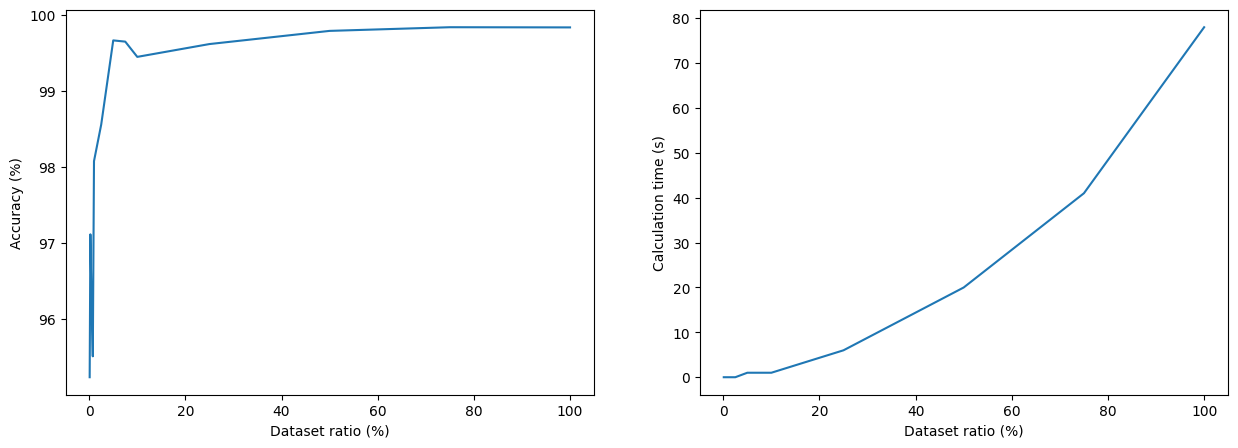

In [61]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.plot( np.array(ratio_range)*100 , np.array(test_acc)*100)
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Accuracy (%)")

#plot 2:
plt.subplot(1, 2, 2)
plt.plot( np.array(ratio_range)*100 , np.array(times) )
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Calculation time (s)")

plt.show()

As we can see ono those graphs, a <u>**bigger**</u> dataset implies an <u>**longer**</u> calculation time. For this dataset, since the maximum calculation time is reasonable (almost a minute) we can consider using the whole dataset, but for more complex models it can be interesting if we want faster predictions.

We can conclude for a KNN that working with only 20% of the dataset allows us to keep a good accuracy while having a computation time that is lower than 10s.

## $\rm{3)}$ Random Forest classifier

In the realm of nonlinear models, random forest is one of the most interesting techniques. The idea behind it is to build several decision trees independently, and then to average their predictions. In particular, each tree is learned from bootstrapped observations, using a random subset of the features at each node split. As a result of this randomness, the combined trees yield a prediction model that is usually better than any of the individual tree.

Unlike the K-Nearest Neighbors algorithm for example, the Random Forest algorithm is not a distance-based model: it is a tree-based model. Indeed, the algorithm is based on partitioning the data to make predictions, therefore, it does not require normalization.

We can then stock our variables for the desired dataset thanks to the function *dataset_distribution()* for our model as it follows:

In [62]:
# Raw
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal")
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2")
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe")

# Truncated
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal", truncated=True)
data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2", truncated=True)
#data, labels, X_train, X_test, y_train, y_test = dataset_distribution("rfe", truncated=True)

We know that Random forest depends on some hyper-parameters. Our first purpose for this part will be to find the best hyper-parameters for each dataset via cross-validation:

In [64]:
# parameters
params_grid = {
    "n_estimators": (40, 60, 80, 100, 120),
    "max_features": (0.2, 0.4, 0.6, 0.8, 1, 'sqrt', 'log2')
}

# cross-validation strategy
cv = KFold(n_splits=5)

# random forest
forest = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf=1, random_state=42)

# hyper-parameter search
forest_cv = GridSearchCV(forest, params_grid, cv=cv, n_jobs=5)
forest_cv.fit(X_train, y_train)

print('Best hyper-params: ' + str(forest_cv.best_params_))

Best hyper-params: {'n_estimators': 80, 'max_features': 0.4}


Once that we have the best hyper-parameters for each dataset, we can set them, fit our model then observe the different results on the test set:

In [65]:
start = time.time()

# init, fit and score
forest_model = RandomForestClassifier(bootstrap=True,
                                max_depth=None,
                                n_estimators=80, 
                                min_samples_leaf=1,
                                max_features=0.4,   
                                random_state=42)

forest_model.fit(X_train, y_train)
base_score = forest_model.score(X_train, y_train)
forest_score = forest_model.score(X_test, y_test)

seconds = round(time.time() - start)

# display
print('Random forest score on train set: {:.4f}'.format(base_score))
print('Random forest score on test set : {:.4f}'.format(forest_score))
print('Elapsed time: {}s'.format(seconds))               

# Raw 
# dataset used       : |   normal   |    chi2    |     rfe    | 
# best hyper-params  : | {0.6, 100} | {0.6, 100} | {0.6, 100} | <-- format: {'max_features', 'n_estimators'}
# score on train set : |   1.0000   |   1.0000   |   1.0000   |
# score on test set  : |   0.9993   |   0.9993   |   0.9993   |    
# computation time   : |     56s    |     33s    |     39s    |
 
# Truncated 
# dataset used       : |   normal   |    chi2    |     rfe    |  
# best hyper-params  : | {0.4, 100} |  {0.4, 80} |  {0.4, 60} | <-- format: {'max_features', 'n_estimators'}
# score on train set : |   1.0000   |   1.0000   |   1.0000   |
# score on test set  : |   0.9978   |   0.9977   |   0.9976   | 
# computation time   : |     6s     |     3s     |     3s     |

Random forest score on train set: 1.0000
Random forest score on test set : 0.9977
Elapsed time: 4s


Here, we can notice that none of our models are overfitting. We can however have two different observations:

- For each non-truncated dataset, we can see that we get the same score, and that only the computation time varies (about 1min to about 30s). 

- When we observe the results from truncated datasets (here 20% of the whole datasets), we can see that the computation time is reduced to about 3s, and that we have the better score (0.9977) with only the 39 kept features from the chi squared test, which is still a great accuracy.

As we can see, it is better to keep a truncated dataset because we save a lot of time without losing much precision. For the random forest, we will keep the dataset_chi2 because we have a better score for a shorter computation time.

The question is now to know the optimal percentage of the dataset to keep an accuracy that remains high :

In [66]:
ratio_range= [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
times = []
train_acc = []
test_acc = []
for ratio in ratio_range:
    data, labels, X_train, X_test, y_train, y_test = dataset_distribution("chi2", truncated=True, ratio=ratio)
    start = time.time()
    model = RandomForestClassifier(bootstrap=True,
                                  max_depth=None,
                                  n_estimators=100, 
                                  min_samples_leaf=1,
                                  max_features=0.4,   
                                  random_state=42)
    
    model.fit(X_train, y_train)
    forest_score = model.score(X_test, y_test)
    seconds = round(time.time() - start)
    base_score = model.score(X_train, y_train)
    test_acc.append(forest_score)
    train_acc.append(base_score)
    times.append(seconds)

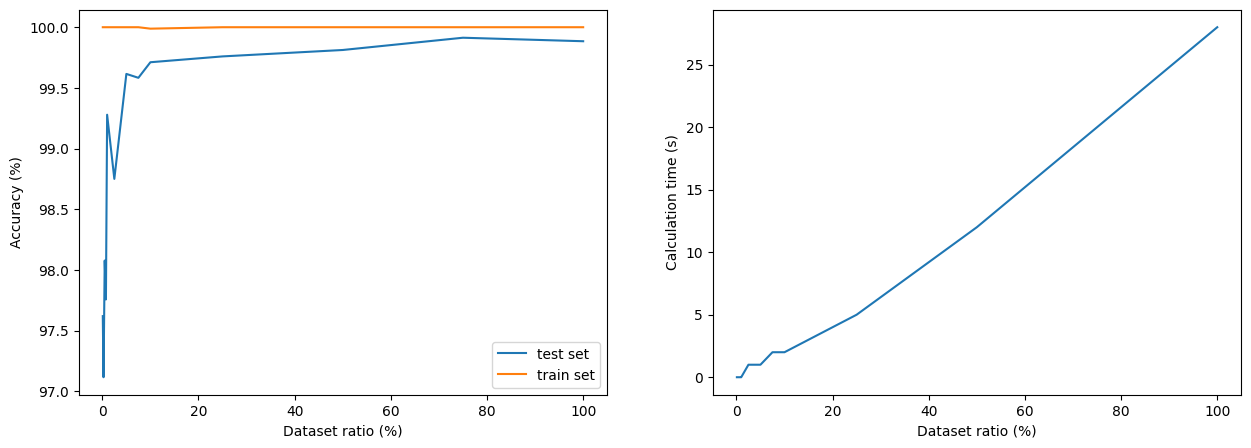

In [67]:
plt.figure(figsize=(15,5))

#plot 1:
plt.subplot(1, 2, 1)
plt.plot( np.array(ratio_range)*100 , np.array(test_acc)*100 , label="test set")
plt.plot( np.array(ratio_range)*100 , np.array(train_acc)*100, label="train set" )
plt.legend()
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Accuracy (%)")

#plot 2:
plt.subplot(1, 2, 2)
plt.plot( np.array(ratio_range)*100 , np.array(times) )
plt.xlabel("Dataset ratio (%)")
plt.ylabel("Calculation time (s)")

plt.show()

Thanks to the plots, we can conclude for a Random Forest that working with only 20% of the dataset allows us to keep a good accuracy while having a computation time that is lower than 5s.

## $\rm{4)}$ Neural Network

The neural network takes a special place in the models chosen. 

Indeed, unlike other models, it is no longer a question of selecting features from among all the data, it will be the network itself that will determine which are the most significant data. This will allow us to obtain a model which, if done well, will perform very well. 

The first thing to do is the preprocessing part, we have already one hot encoded the data, so lets split the dataset in 2 parts. The first one, the training part will consist on train the neural network with 80% of the data set. The second one is the test part with 20% of the data set to validate our model.

In fact, the preprocessing part was done before, and the "normal" value means we take the whole data shaping in the good format.

In [72]:
data, labels, X_train, X_test, y_train, y_test = dataset_distribution("normal", scaled=True)

Then we have to create the model. 

The first thing to put is the value of the input shape. We know that the shape of the test data and the train data were reshape in ('Something',119). The 'something means the number of rows. That gives the input shape (None, 119). 

Then we want a classification in multiple values, so whe have to put a softmax function of activation for the last layer. And we have to select a number of perceptron equals to the length of the labels that we want to classify.For the other activations functions we chose the ReLU funtion and the number of neuron that we want.

In the same way, during the compilation of the model, we have to chose the loss 'categorical_crossentropy' to classify into more than two categories.

After many tries, we select those parameters which sems pretty good. 

In [73]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',input_shape=(None, 119)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 64)          7680      
                                                                 
 dense_5 (Dense)             (None, None, 128)         8320      
                                                                 
 dense_6 (Dense)             (None, None, 32)          4128      
                                                                 
 dense_7 (Dense)             (None, None, 5)           165       
                                                                 
Total params: 20,293
Trainable params: 20,293
Non-trainable params: 0
_________________________________________________________________


Finally, we need to train the model, we chose a batch size of 200 for 60 epochs.

In [74]:
start = time.time()
history = model.fit(X_train, y_train, epochs=60, batch_size=200, validation_split=0.2)
seconds = round(time.time() - start)

Epoch 1/60
338/338 [==============================] - 3s 5ms/step - loss: 0.1346 - accuracy: 0.9704 - val_loss: 0.0210 - val_accuracy: 0.9937
Epoch 2/60
338/338 [==============================] - 2s 4ms/step - loss: 0.0173 - accuracy: 0.9953 - val_loss: 0.0163 - val_accuracy: 0.9940
Epoch 3/60
338/338 [==============================] - 2s 5ms/step - loss: 0.0125 - accuracy: 0.9957 - val_loss: 0.0103 - val_accuracy: 0.9966
Epoch 4/60
338/338 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0114 - val_accuracy: 0.9962
Epoch 5/60
338/338 [==============================] - 2s 5ms/step - loss: 0.0084 - accuracy: 0.9970 - val_loss: 0.0093 - val_accuracy: 0.9970
Epoch 6/60
338/338 [==============================] - 2s 5ms/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 7/60
338/338 [==============================] - 2s 5ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0095 - val_accuracy: 0.9968
Epoch 

And we plot the training and the test values.

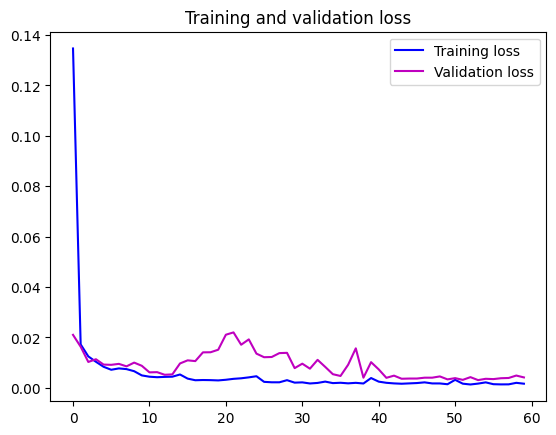

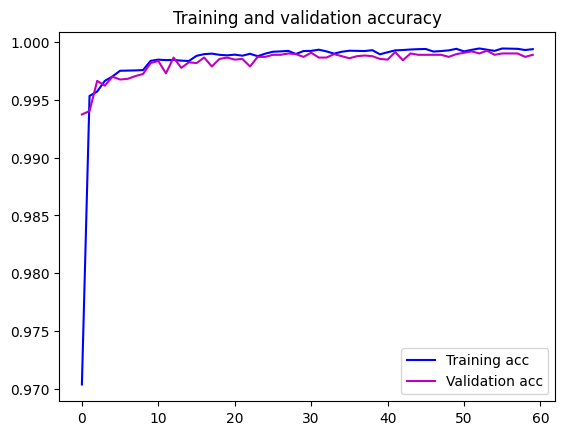

1300/1300 [==============================] - 3s 3ms/step - loss: 0.0123 - accuracy: 0.9985
Test accuracy: 99.84845519065857 %
Elapsed time: 1min 37s


In [75]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

valid_loss, valid_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", valid_acc*100, "%")

minutes = seconds // 60
seconds %= 60
print('Elapsed time: {}min {}s'.format(minutes, seconds)) 

We can see that the model have an accuracy of 99,85% and almost no overfit. So the neural network is very efficient in those data. Compared to the previous models, we can see that the neural network is time-consuming without having the best accuracy.

# $\rm{IV}$<b> - Result on the *Test.csv* file</b>

## $\rm{1)}$ Recovering and manipulating the data

For this last part, we first need to recover the file *Test.csv* in order to make the predictions on it. We will then use our oneHotEncoder from the part $\rm{I-5)}$ to reshape or dataframe :

In [76]:
df_test = pd.read_csv(projectPath+'data/Test.csv', index_col=False) 

with open(projectPath+'data/oneHotEncoder.pickle', 'rb') as fp :
    oneHotEncoder = pickle.load(fp)  

# Extract the categorical variables
categorical = df_test.select_dtypes(include=[object])

# Transform
encoded = oneHotEncoder.transform(categorical).toarray()

# Keep the result into a dataframe
encoded = pd.DataFrame(encoded, columns=oneHotEncoder.get_feature_names_out())

# Drop the categorical data from the original dataframe
df_test.drop(df_test.select_dtypes(include=[object]), axis=1, inplace=True) 

# Join the oneHotEncoded data to the dataframe
df_test = df_test.join(encoded) 

# Result
print("Shape :", df_test.shape)
df_test.head(5)

Shape : (100, 123)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,15,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## $\rm{2)}$ Model prediction

Once that we manipulated the dataframe from *Test.csv*, we will take our best model to make the prediction on it. 

Here, we will use the Random Forest Classifier because this is with this model that we had the best performances (3s computation time, score of 0.9977 with only 39 features).

First, we need to recover the dataset from the training part in order to keep only the 39 most important features on our *Test.csv*.

In [77]:
dataset_name = "chi2"
ratio = 0.2

X_train, _ = dataset_recovering(dataset_name)
X_test = df_test[list(X_train.columns.values)]

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)

X_train : (125973, 39)
X_test  : (100, 39)


Then, we can make our predictions on the *Test.csv* file, as it follows :

In [78]:
y_pred = forest_model.predict(X_test)

predictions = np.argmax(y_pred, axis=1)
predictions = pd.DataFrame(predictions)
predictions.columns = ['predictions']

attack_list = ['attack_DoS', 'attack_Probe', 'attack_R2L', 'attack_U2R', 'attack_noAttack']
for i in range(len(attack_list)):
    predictions = predictions.replace(i, attack_list[i])

predictions.head(10)

,predictions
0,attack_DoS
1,attack_DoS
2,attack_noAttack
3,attack_Probe
4,attack_DoS
5,attack_noAttack
6,attack_noAttack
7,attack_noAttack
8,attack_noAttack
9,attack_DoS


## $\rm{3)}$ Final result

To have a better format of the predictions and easily compare them with the true result, we will store *y_pred* into a *.csv* file. This will allows to keep the labels and to easily convert it into a numpy array if needed. 

In [79]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = attack_list

In [80]:
y_pred.to_csv('./data/final_prediction.csv', index=False)

In [83]:
final_prediction = pd.read_csv(projectPath+'data/final_prediction.csv', index_col=False) 

final_prediction.head(3)

,attack_DoS,attack_Probe,attack_R2L,attack_U2R,attack_noAttack
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
